In [1]:
#importing numpy and pandas to store, manipulate and process data
import pandas as pd
import numpy as np
#importing regular expressions librarires for pre- processing 
import re, string, unicodedata
#importing these libraries for pre-processing purposes
#use pip install contractions to install them
import contractions
import inflect
#importing bs4 to identify and remove web-tags
from bs4 import BeautifulSoup
#nltk is used for natural language processing
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [2]:
#importing pre-processing libraries from keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
#importing keras to access machine learning model
from keras.models import Sequential
#importing keras for defining neutral netwrok
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
#importing sklearn 
from sklearn.model_selection import train_test_split

import keras

In [3]:
from scipy.stats import gamma 

In [4]:
from nlppreprocess import NLP

In [5]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\podda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df=pd.read_csv("D:\sentiment-analysis-GUI/Book3.csv")

In [7]:
df.head()
print (len(df))

999999


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

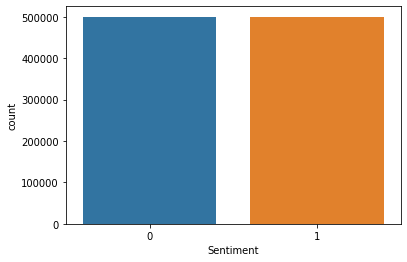

In [8]:
#graph showing how many positive and negative sentiments
#postive is represented by 1 and negative by 0
import seaborn as sns
sns.countplot(x='Sentiment', data=df)

In [9]:
df["no_of_words"]= [len(df.iloc[i,0]) for i in range(0,len(df))]
df["no_of_words_trimmed"]= [len(df.iloc[i,0]) for i in range(0,len(df))]

In [10]:
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import math

<AxesSubplot:xlabel='no_of_words'>

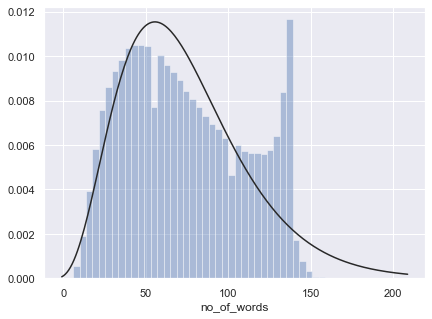

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df["no_of_words"], kde=False, fit=gamma)

<AxesSubplot:xlabel='no_of_words_trimmed'>

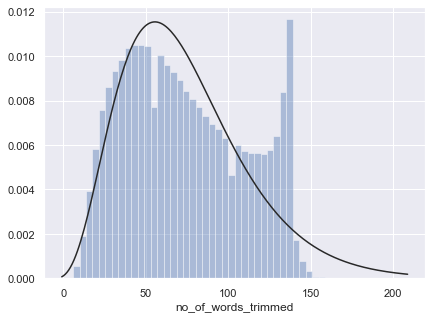

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df["no_of_words_trimmed"], kde=False, fit=gamma)

In [16]:
stop_words= stopwords.words('english')
nlp = NLP()
def pre_pro(text):
  
  #print(text)
  
  
#HTML tags were found in the text so Bs4 was used to strip them to get better sentiments as HTML tags are <br> doesnt help in sentiment analysis
  def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


#removing the square brackets as it increase inconsistencies in pre-processing
  def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)



  def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


#we have to remove contraction to get clear idea of the text. like 'you'll' will get converted into 'you will'
  def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)    


  #removing indentified general pattern names starting with @ and #tags. when we scrap a data from the web it may contain symbols like '@' and '%' which do not tell us about the setiments of the sentences .Thus they are removed. 
  text=" ".join (word for word in text.split() if word[0] not in ['@', '#'])
  
  #denoise
  
  text=denoise_text(text)
  
  #removing stop words. stop wods are words like 'and' , 'if' etc which do not have any role in setimental analysis hence they are removed.
#   print(text)
#   text=" ".join (word for word in text.split() if word not in stop_words)
  text=nlp.process(text) 

  #removing line skip. replaces the unneeded elements by blankspace
  text=text.replace('[^\w\s]','')
  
  # Remove punctuations and numbers. punctuation like !, ? and numbers are not used in sentimental analysis 
  text = re.sub('[^a-zA-Z]', ' ', text)
  
  #lowercase. Changing into lower case for uniform datastructure
  text=" ".join (word.lower() for word in text.split())
 
 #contraction.
  text=replace_contractions(text)

  # Single character removal
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

  # Removing multiple spaces
  text = re.sub(r'\s+', ' ', text)
  

  
  return text

In [17]:
df["processed"]= [pre_pro(df.iloc[i,0]) for i in range(0,len(df))]

In [18]:
X=df["processed"]

In [19]:
import gc
gc.collect()

24275

In [22]:
#tokenizing data and spliting it into tokens 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
#defining the tokened variables
X = tokenizer.texts_to_sequences(X)
import pickle
# saving
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 25
X = pad_sequences(X, padding='post', maxlen=maxlen)


In [24]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('D:\glove.twitter.27B\glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [25]:
embedding_matrix = zeros((vocab_size, 200))
#i=0 
for word, index in tokenizer.word_index.items():
    #Statements for debugging error during runtime
    # print(i)
    # i+=1
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 
                            200, 
                            weights=[embedding_matrix], 
                            input_length=maxlen,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           45153200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 45,321,906
Trainable params: 168,706
Non-trainable params: 45,153,200
_________________________________________________________________


In [28]:
history = model.fit(X, 
keras.utils.to_categorical(df["Sentiment"]), 
batch_size=128, 
epochs=10, 
verbose=1, 
validation_split=0.1)

Epoch 1/10
7032/7032 [==============================] - 455s 65ms/step - loss: 0.4307 - acc: 0.8001 - val_loss: 0.4057 - val_acc: 0.8124
Epoch 2/10
7032/7032 [==============================] - 440s 63ms/step - loss: 0.3932 - acc: 0.8216 - val_loss: 0.3968 - val_acc: 0.8192
Epoch 3/10
7032/7032 [==============================] - 390s 55ms/step - loss: 0.3759 - acc: 0.8305 - val_loss: 0.3848 - val_acc: 0.8245
Epoch 4/10
7032/7032 [==============================] - 392s 56ms/step - loss: 0.3622 - acc: 0.8381 - val_loss: 0.3823 - val_acc: 0.8257
Epoch 5/10
7032/7032 [==============================] - 416s 59ms/step - loss: 0.3502 - acc: 0.8442 - val_loss: 0.3859 - val_acc: 0.8240
Epoch 6/10
7032/7032 [==============================] - 398s 57ms/step - loss: 0.3389 - acc: 0.8500 - val_loss: 0.3901 - val_acc: 0.8244
Epoch 7/10
7032/7032 [==============================] - 390s 55ms/step - loss: 0.3280 - acc: 0.8553 - val_loss: 0.4006 - val_acc: 0.8232
Epoch 8/10
7032/7032 [===================

In [29]:
model.save('my_model2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model2\assets


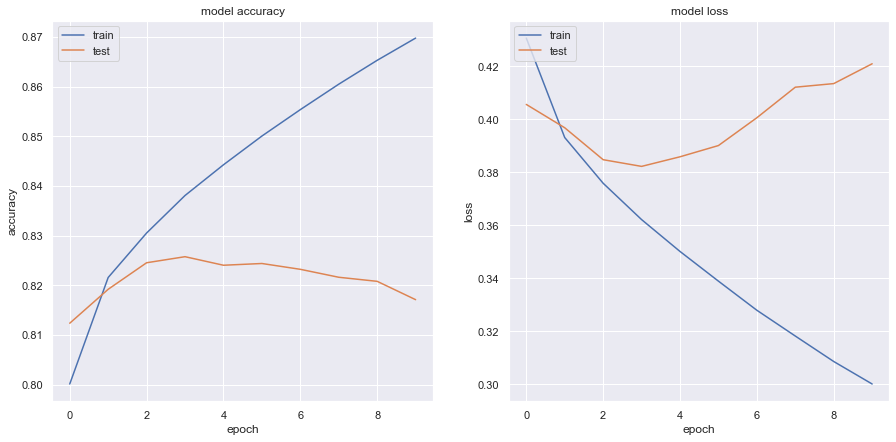

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()